In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

In [ ]:
## code for preparing the data set, combine all csv files
# model_list_names = ["no_context_bert_predictions", "context_bert_predictions",
#               "no_context_longformer_predictions", "context_longformer_predictions"]


# for model_name in model_list_names:
#   df = pd.read_csv(f"/content/drive/MyDrive/ANLP/preds/{model_name}/predictions1.csv")
#   df.sort_values(by=['song_id', 'text'], inplace=True)
#   df.reset_index(drop=True, inplace=True)
#   df.rename(columns={'pred_label': 'model1_pred_label', 'prob_0': 'model1_prob_0', 'prob_1': 'model1_prob_1'}, inplace=True)
#   for i in range(4):
#     temp_df = pd.read_csv(f"/content/drive/MyDrive/ANLP/preds/{model_name}/predictions{i+2}.csv")
#     temp_df.sort_values(by=['song_id', 'text'], inplace=True)
#     temp_df.reset_index(drop=True, inplace=True)
#     df[f"model{i+2}_pred_label"] = temp_df["pred_label"]
#     df[f"model{i+2}_prob_0"] = temp_df["prob_0"]
#     df[f"model{i+2}_prob_1"] = temp_df["prob_1"]
#   df.to_csv(f"/content/drive/MyDrive/ANLP/preds/{model_name}/combined_predictions.csv", index=False)

In [ ]:
song_df = pd.read_parquet("hf://datasets/mrYou/Lyrics_eng_dataset/data/train-00000-of-00001.parquet")
song_df = song_df[["id", "tag", "year"]]
song_df.rename(columns={'id': 'song_id'}, inplace=True)

In [14]:
model_list_names = ["no_context_bert_predictions", "context_bert_predictions",
              "no_context_longformer_predictions", "context_longformer_predictions"]

model_list_acc = []
model_list_acc_std = []

for model_name in model_list_names:
  df = pd.read_csv(f"/content/drive/MyDrive/ANLP/preds/{model_name}/combined_predictions.csv")
  model_accuracy_list = []
  for i in range(5):
    model_accuracy_list.append((df[f'model{i+1}_pred_label'] == df['label']).mean())
  model_accuracy = np.array(model_accuracy_list).mean()
  model_list_acc_std.append(np.array(model_accuracy_list).std())
  model_list_acc.append(model_accuracy)

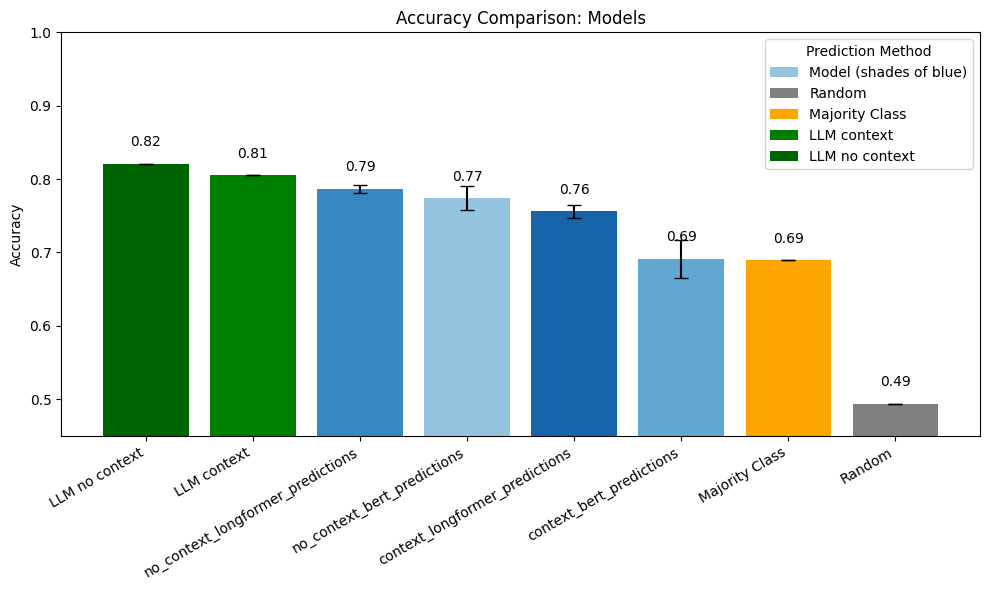

In [19]:
random_preds = np.random.randint(0, 2, size=len(df))
random_accuracy = (random_preds == df['label']).mean()

majority_class = df['label'].value_counts().idxmax()
majority_preds = np.full_like(df['label'], fill_value=majority_class)
majority_accuracy = (majority_preds == df['label']).mean()
LLM_acc = [0.805, 0.821]

# Combine all results
all_names = model_list_names + ['Random', 'Majority Class', 'LLM context', 'LLM no context']

all_accuracies = model_list_acc + [random_accuracy, majority_accuracy, LLM_acc[0], LLM_acc[1]]

# Extend std list with 0 for baselines
all_stds = model_list_acc_std + [0, 0, 0, 0]

# Generate unique shades of blue for models
model_colors = cm.Blues(np.linspace(0.4, 0.8, len(model_list_names)))
color_map = dict(zip(model_list_names, model_colors))

# Add fixed colors for baselines
color_map.update({'Random': 'gray', 'Majority Class': 'orange', 'LLM context': 'green', 'LLM no context': 'darkgreen'})

# Assign colors for all bars
bar_colors = [color_map[name] for name in all_names]

# Sort all data by accuracy
sorted_data = sorted(zip(all_names, all_accuracies, bar_colors, all_stds), key=lambda x: x[1], reverse=True)
sorted_names, sorted_accs, sorted_colors, sorted_stds = zip(*sorted_data)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_names, sorted_accs, yerr=sorted_stds, color=sorted_colors, capsize=5)
plt.ylim(0.45, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Models')

# Rotate x-axis labels
plt.xticks(rotation=30, ha='right')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
             f'{height:.2f}', ha='center', va='bottom')
# Legend
legend_elements = [
    Patch(facecolor=model_colors[0], label='Model (shades of blue)'),
    Patch(facecolor='gray', label='Random'),
    Patch(facecolor='orange', label='Majority Class'),
    Patch(facecolor='green', label='LLM context'),
    Patch(facecolor='darkgreen', label='LLM no context')
]

plt.legend(handles=legend_elements, title='Prediction Method')

plt.tight_layout()
plt.show()

# Error Analysis

In [6]:
df["correct"] = df["label"] == df["model1_pred_label"]

# Get False Positives (FP): model predicted chorus but it was not
false_positives = df[(df["model1_pred_label"] == 1) & (df["label"] == 0)]

# Get False Negatives (FN): model missed a chorus
false_negatives = df[(df["model1_pred_label"] == 0) & (df["label"] == 1)]


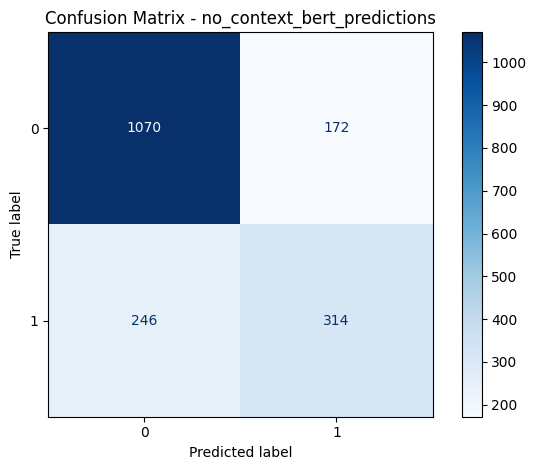

Precision: 0.646
Recall:    0.561


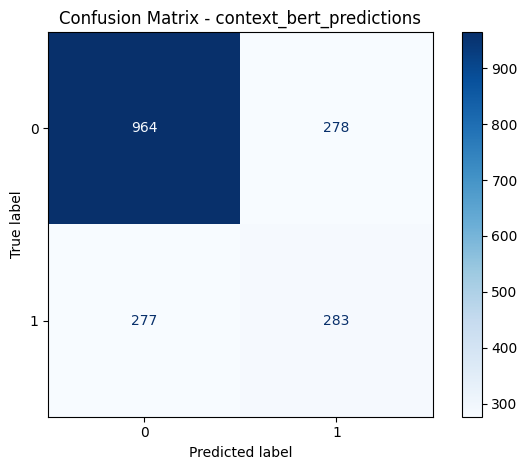

Precision: 0.504
Recall:    0.505


In [41]:
# True labels and predicted labels
for model_name in model_list_names:
  df = pd.read_csv(f"/content/drive/MyDrive/ANLP/preds/{model_name}/combined_predictions.csv")
  y_true = df['label']
  y_pred = df['model1_pred_label']

  # Generate confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Optional: for class labels (use if your classes are not 0/1)
  labels = sorted(df['label'].unique())

  # Plot confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='d')  # 'd' for integer display
  plt.title(f'Confusion Matrix - {model_name}')
  plt.grid(False)
  plt.tight_layout()
  plt.show()

  precision = precision_score(y_true, y_pred, average='binary')  # change to 'macro' or 'weighted' for multiclass
  recall = recall_score(y_true, y_pred, average='binary')

  print(f'Precision: {precision:.3f}')
  print(f'Recall:    {recall:.3f}')

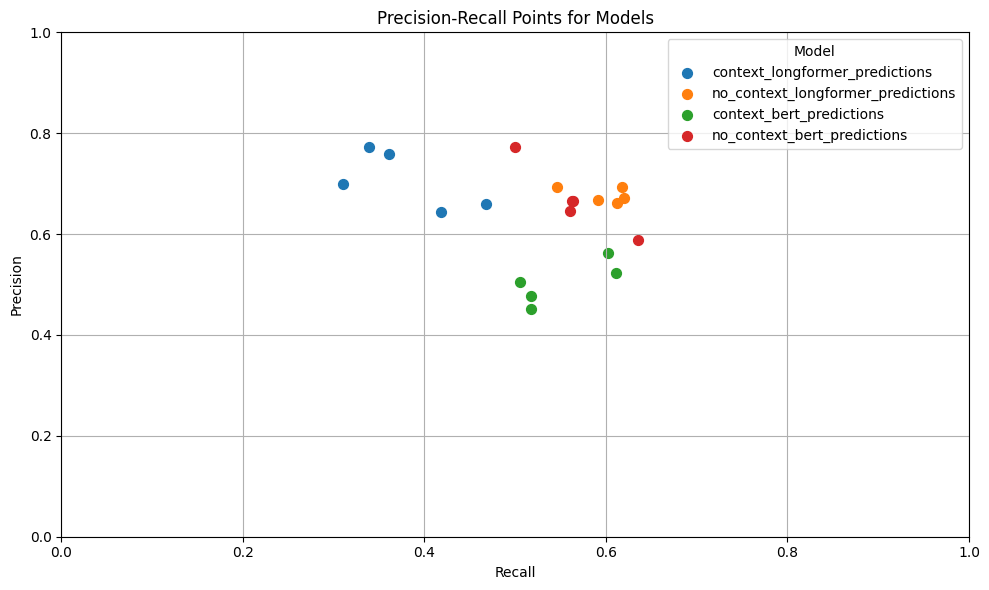

In [54]:
precision_arr = []
recall_arr = []
model_arr = []

# Assuming all models have the same number of prediction files (5 in this case)
num_files = 5

for model_name in model_list_names:
  # Reset df for each model to ensure correct file reading
  df = pd.read_csv(f"/content/drive/MyDrive/ANLP/preds/{model_name}/combined_predictions.csv")
  y_true = df['label']
  for i in range(num_files):
    pred_col = f"model{i+1}_pred_label"
    y_pred = df[pred_col]
    precision_arr.append(precision_score(y_true, y_pred))
    recall_arr.append(recall_score(y_true, y_pred))
    model_arr.append(model_name)


# Plotting
plt.figure(figsize=(10, 6))
# Use plt.scatter instead of sns.scatter
for model_name in set(model_arr): # Iterate over unique model names for plotting
    model_indices = [i for i, name in enumerate(model_arr) if name == model_name]
    plt.scatter(np.array(recall_arr)[model_indices], np.array(precision_arr)[model_indices], label=model_name, s=50)


# Axis setup
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Points for Models') # Adjusted title
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(title='Model') # Added legend title
plt.tight_layout()
plt.show()

# Year Analysis

In [9]:
new_df = song_df.merge(df, on="song_id")
new_df.head()

,song_id,tag,year,text,context,label,model1_pred_label,model1_prob_0,model1_prob_1,model2_pred_label,...,model2_prob_1,model3_pred_label,model3_prob_0,model3_prob_1,model4_pred_label,model4_prob_0,model4_prob_1,model5_pred_label,model5_prob_0,model5_prob_1
0,4843915,country,2019,Came out here to do a whole lot of nothing and...,Starin’ at the prettiest part of this powder k...,0,0,0.999998,0.000002,0,...,0.000003,0,1.0,1.225524e-07,0,0.998407,0.001593,0,0.999971,0.000029
1,4843915,country,2019,Dipping our toes in the water\nI don’t care if...,Starin’ at the prettiest part of this powder k...,1,0,0.999998,0.000002,0,...,0.000004,0,1.0,1.284455e-07,0,0.999322,0.000678,0,0.996787,0.003213
2,4843915,country,2019,Starin’ at the prettiest part of this powder k...,Dipping our toes in the water\nI don’t care if...,0,0,0.999999,0.000001,0,...,0.000004,0,1.0,4.274002e-08,0,0.999528,0.000472,0,0.992632,0.007368
3,6160165,country,2021,I rolled in bumpin' 10's into Broadway\nDirty ...,So let's ditch this hole-in-the-wall\nMix some...,0,0,0.999999,0.000001,0,...,0.000003,0,1.0,3.954902e-08,0,0.999933,0.000067,0,0.999976,0.000024
4,6160165,country,2021,I'll close thе tab quick\nWe can go get half-l...,I rolled in bumpin' 10's into Broadway\nDirty ...,0,0,0.998420,0.001580,0,...,0.000003,0,1.0,1.204981e-07,0,0.999388,0.000612,0,0.535222,0.464778


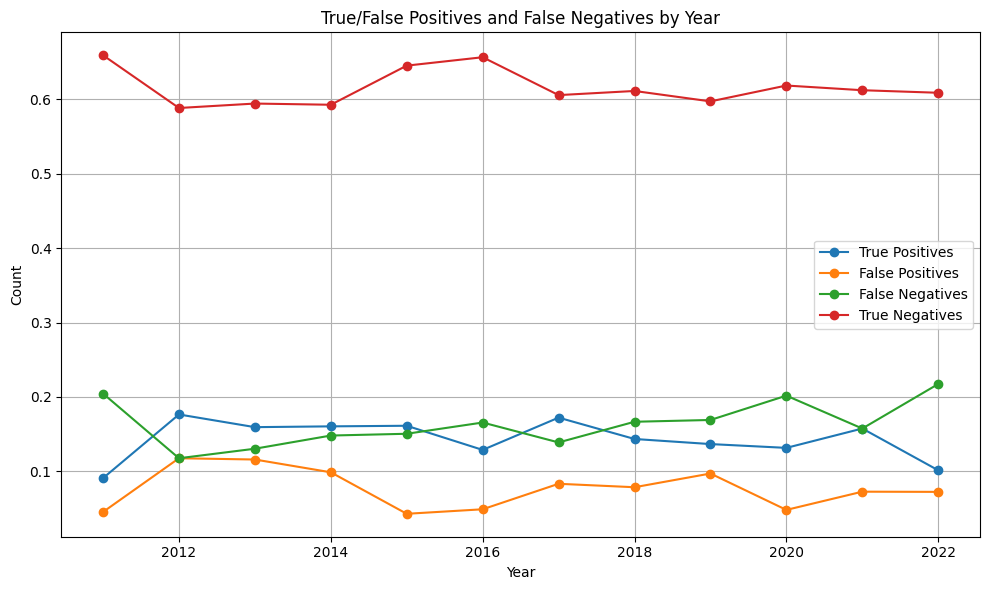

In [23]:
def compute_metrics_per_year(df):
    results = []

    for year, group in df.groupby('year'):
        y_true = group['label']
        y_pred = group['model1_pred_label']

        tp = ((y_true == 1) & (y_pred == 1)).mean()
        fp = ((y_true == 0) & (y_pred == 1)).mean()
        fn = ((y_true == 1) & (y_pred == 0)).mean()
        tn = ((y_true == 0) & (y_pred == 0)).mean()

        results.append({'year': year, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn})

    return pd.DataFrame(results).sort_values('year')

# Compute metrics
yearly_metrics = compute_metrics_per_year(new_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(yearly_metrics['year'], yearly_metrics['TP'], marker='o', label='True Positives')
plt.plot(yearly_metrics['year'], yearly_metrics['FP'], marker='o', label='False Positives')
plt.plot(yearly_metrics['year'], yearly_metrics['FN'], marker='o', label='False Negatives')
plt.plot(yearly_metrics['year'], yearly_metrics['TN'], marker='o', label='True Negatives')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('True/False Positives and False Negatives by Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Genre Analysis

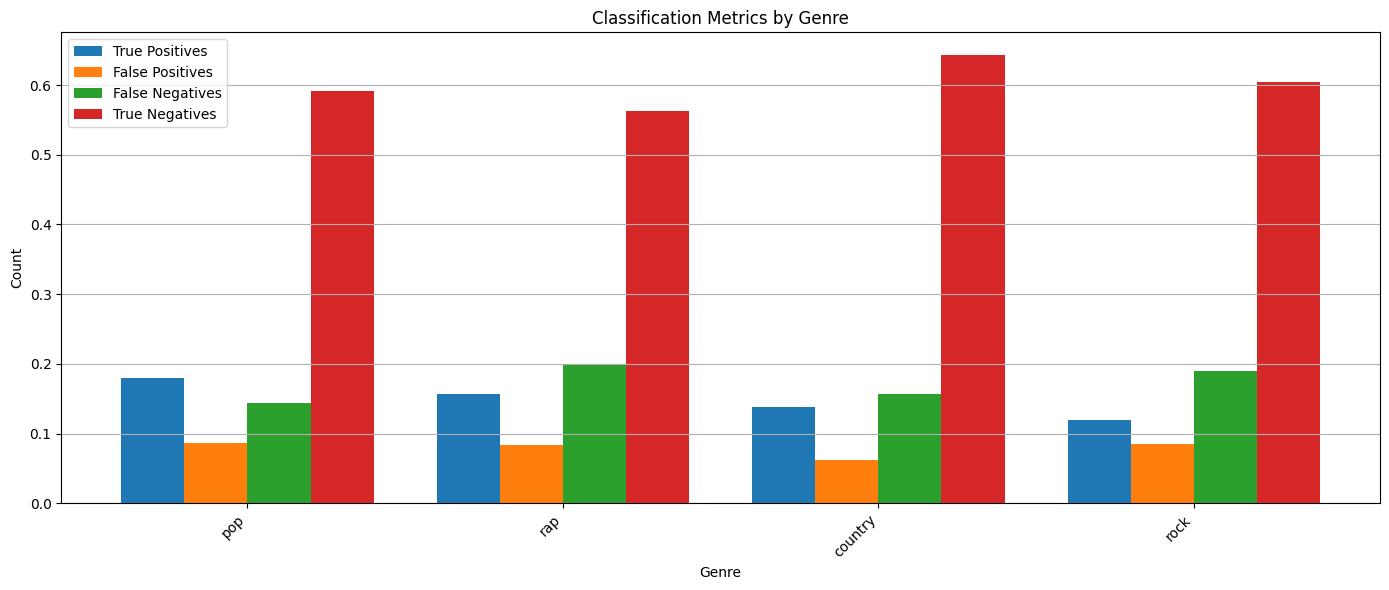

In [35]:
def compute_metrics_per_genre(df):
    results = []

    for genre, group in df.groupby('tag'):
        y_true = group['label']
        y_pred = group['model1_pred_label']

        tp = ((y_true == 1) & (y_pred == 1)).mean()
        fp = ((y_true == 0) & (y_pred == 1)).mean()
        fn = ((y_true == 1) & (y_pred == 0)).mean()
        tn = ((y_true == 0) & (y_pred == 0)).mean()

        results.append({'genre': genre, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn})

    return pd.DataFrame(results).sort_values('TP', ascending=False)

# Compute genre-level metrics
genre_metrics = compute_metrics_per_genre(new_df)

# Plotting
bar_width = 0.2
spacing = 0.2  # extra space between genre groups

# Compute x positions with spacing between genres
x = np.arange(len(genre_metrics)) * (4 * bar_width + spacing)

plt.figure(figsize=(14, 6))

# Plot bars with offsets within each genre group
plt.bar(x - 1.5 * bar_width, genre_metrics['TP'], width=bar_width, label='True Positives')
plt.bar(x - 0.5 * bar_width, genre_metrics['FP'], width=bar_width, label='False Positives')
plt.bar(x + 0.5 * bar_width, genre_metrics['FN'], width=bar_width, label='False Negatives')
plt.bar(x + 1.5 * bar_width, genre_metrics['TN'], width=bar_width, label='True Negatives')

# Set x-ticks to genre labels with spacing
plt.xticks(ticks=x, labels=genre_metrics['genre'], rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Classification Metrics by Genre')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# wordCloud

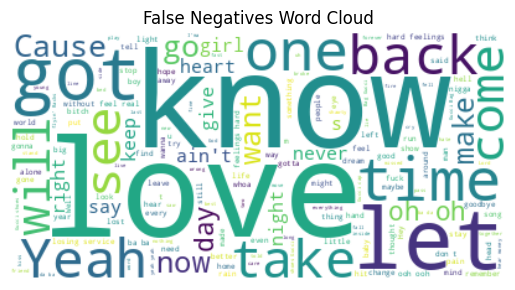

In [7]:
# WordCloud for false negatives (missed chorus)
text_fn = " ".join(false_negatives["text"].values)
wordcloud = WordCloud(background_color='white').generate(text_fn)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("False Negatives Word Cloud")
plt.show()

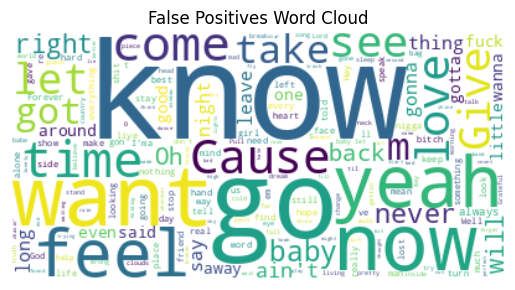

In [8]:
# WordCloud for false positives (missed non chorus)
text_fn = " ".join(false_positives["text"].values)
wordcloud = WordCloud(background_color='white').generate(text_fn)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("False Positives Word Cloud")
plt.show()

# Logits - Where the Model Unsure

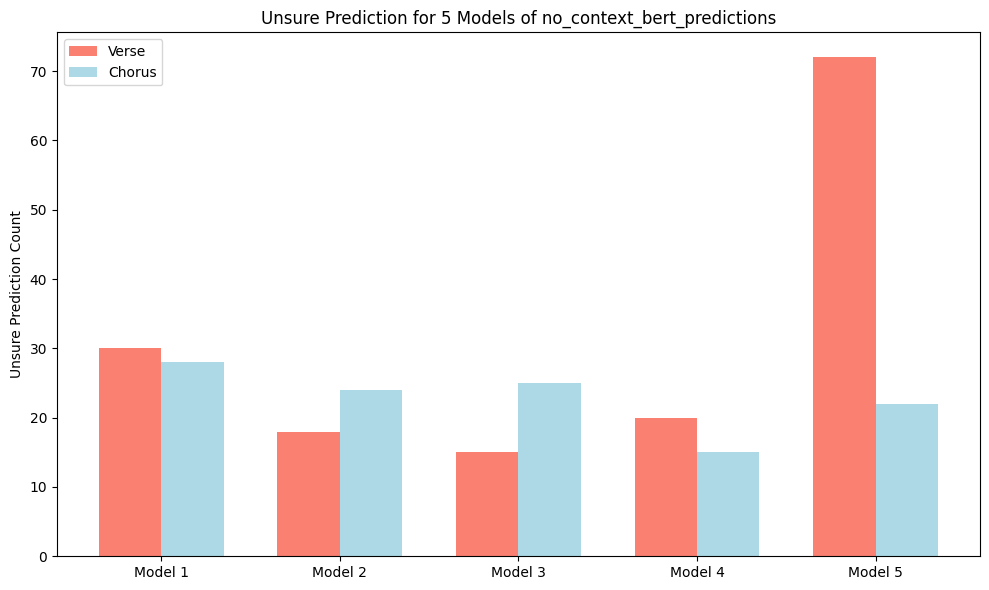

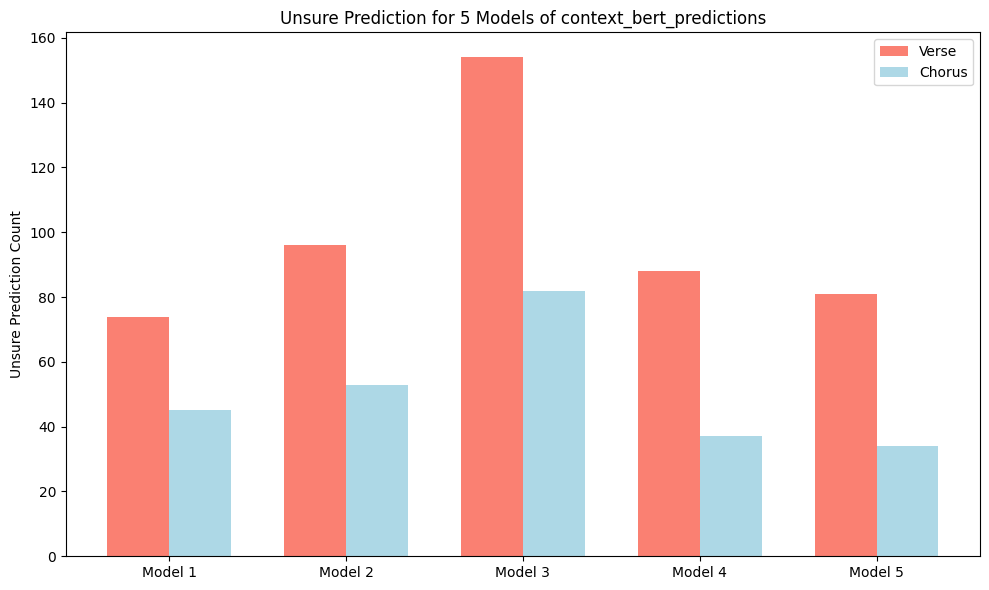

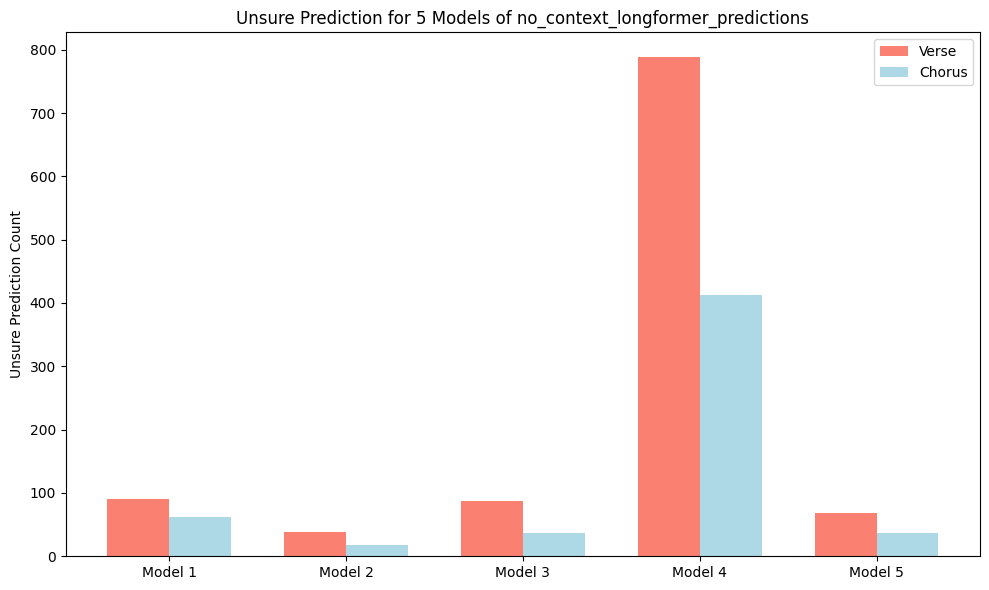

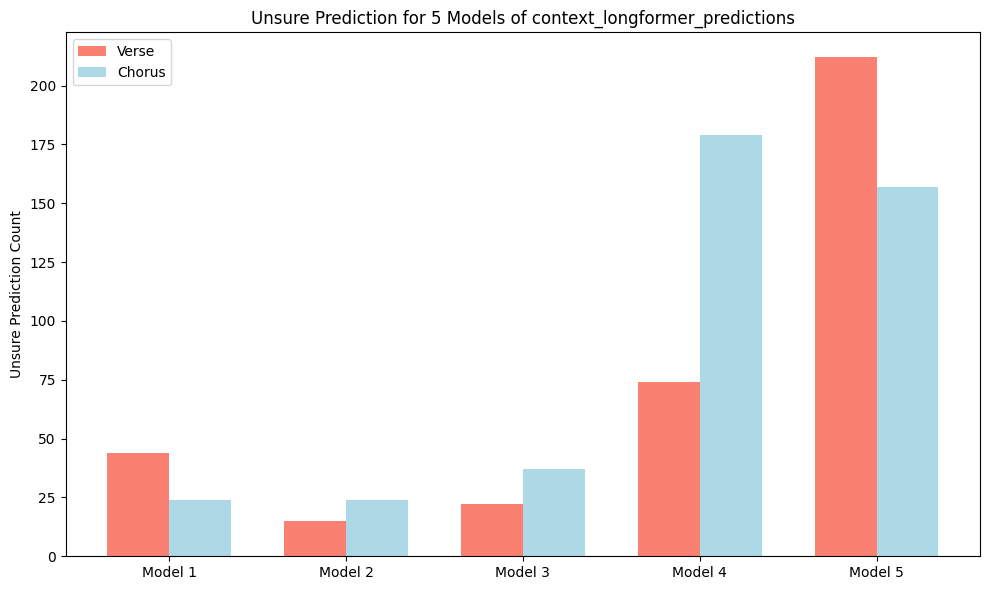

In [21]:
for model_name in model_list_names:
  df = pd.read_csv(f"/content/drive/MyDrive/ANLP/preds/{model_name}/combined_predictions.csv")
  label_0_counts = []
  label_1_counts = []

  for i in range(5):
    unsure_df = df[(df[f"model{i+1}_prob_0"] < 0.9) & (df[f"model{i+1}_prob_0"] > 0.1)]
    counts = unsure_df['label'].value_counts()
    label_0_counts.append(counts.get(0, 0))  # Get count of label 0, default to 0 if not present
    label_1_counts.append(counts.get(1, 0))
  model_rep = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']


  x = np.arange(len(model_rep))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots(figsize=(10, 6))
  bars0 = ax.bar(x - width/2, label_0_counts, width, label='Verse', color='salmon')
  bars1 = ax.bar(x + width/2, label_1_counts, width, label='Chorus', color='lightblue')

  # Add some text for labels, title and axes ticks
  ax.set_ylabel('Unsure Prediction Count')
  ax.set_title(f'Unsure Prediction for 5 Models of {model_name}')
  ax.set_xticks(x)
  ax.set_xticklabels(model_rep)
  ax.legend()

  plt.tight_layout()
  plt.show()